<a href="https://colab.research.google.com/github/virf96/Proyectos/blob/master/Consideraciones_combincion_ARMA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consideraciones modelo ARMA (Autorregresivo de medias móviles)

Este modelo combina el método autorregresivo y medias móviles, este modelo considera el valor de la varible en el periodo anterior y el residuo en el periodo anterior.

**Modelo ARMA más simple**

**ARMA(1,1):**$x_{t}=c+\phi_{1}x_{t-1}+\theta_{1}\epsilon_{t-1}+\epsilon_{t}$

donde:

$x_{t}$ = Valor de la variable en el perido $t$

$c$ = Una constante

$\phi_{1}$ = parámetro a estimar

$x_{t-1}$ = Valor de la variable en el pariodo $t-1$

$\theta_{1}$ = parámetro a estimar

$\epsilon_{t-1}$ = Residuo en el perido $t-1$

$\epsilon_{t}$ = Residuo en el perido $t$





## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing the Data and Pre-processing 

In [2]:
#Cargamos los datos
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/virf96/curso-series-temporales/master/2.%20Serie%20temporal%20en%20R%20y%20Python/Python/Index2018.csv") 
#Copiamos el df en otra variable
df_comp=raw_csv_data.copy()
#Convertimos la variable "date" a formato fecha indicando que la variable tiene primero el día
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#Indexamos la fecha
df_comp.set_index("date", inplace=True)
#Indicamos que la frecuencia es "business days"
df_comp=df_comp.asfreq('b')

In [3]:
df_comp.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [4]:
#Verificamos que no haya NA´s
df_comp.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [5]:
#Rellenamos los NA´s con el método "front fill"
df_comp=df_comp.fillna(method='ffill')

In [6]:
#Renombramos ftse
df_comp['market_value']=df_comp.ftse

In [7]:
#Borramos las variables que no ocuparemos
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
#Indicamos el punto de corte para el set de entrenamiento y prueba
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [8]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [9]:
#Definimos el contraste de log verosimilitud
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [10]:
#Guardamos los retornos de la variable, recordando que unicamente es la tasa de variación entre un día y otro, lo multiplicamos por 100 para obtener una tasa
#Tomamos los retornos dado que estos si son estacionarios y necesariamente debe cumplir ese supuesto la serie
df['returns'] = df.market_value.pct_change(1)*100

In [11]:
df.head()

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


## ARMA(1,1)

In [14]:
#Definimos el modelo ARMA(1,1)
model_ret_ar_1_ma_1 = ARMA(df.returns[1:], order=(1,1))
#Ajustamos el modelo
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
#Resumen del modelo
#Observamos que tanto el retraso del modelo AR (variable en el periodo t-1) como el retraso del MA (residuos en el periodo t-1) son significativos
#El coeficiente auteorregresivo tiene sigmo positivo sugiere que hay una tendencia positiva entre valores pasados y presentes
results_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Fri, 17 Jul 2020   AIC                          15841.000
Time:                        01:46:13   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -13.406      0.000      -0.933      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3074           +0.0000j            1.3074            0.0000
MA.1            1.2284           +0.0000j            1.2284            0.0000
-----------------------------------------------------------------------------
"""

In [12]:
#Defimismo el modelo AR(1) Y MA(1) para compararlo con el ARMA(1,1)
model_ret_ar_1 = ARMA(df.returns[1:], order = (1,0))
model_ret_ma_1 = ARMA(df.returns[1:], order = (0,1))
results_ret_ar_1 = model_ret_ar_1.fit()
results_ret_ma_1 = model_ret_ma_1.fit()

In [15]:
#En este caso no hay que definir los grados de libertad dado que por defecto "DF=1"
#La prueba es significativa por lo que nos quedamos con ARMA(1,1)
print("\nARMA vs AR ", LLR_test(results_ret_ar_1, results_ret_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(results_ret_ma_1, results_ret_ar_1_ma_1))


ARMA vs AR  0.0

ARMA vs MA  0.0


## Higher-Lag ARMA Models

¿Como definimos cuantos retrasos para un modelo **ARMA**?

1.   Empezaremos definiendo un modelo complejo, es decir, un número grande para el componete autorregresivo como para el de medias moviles.
$x_{t}=c+\phi_{1}x_{t-1}+\phi_{2}x_{t-2}+...+\phi_{n}x_{t-n}+\theta_{1}\epsilon_{t-1}+\theta_{2}\epsilon_{t-2}+...+\theta_{n}\epsilon_{t-n}+\epsilon_{t}$

2.   Iremos disminuyendo el número de componentes **hasta llegar al más simple** que contenga **todos los coeficientes significativos**, en donde la **log-verosimilitud sea alta** y donde el **criterio de información BIC ó AIC sea bajo**  




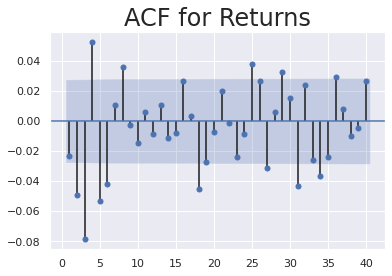

In [17]:
#Gráfica de autocorrelación para los retornos
#La gráfica indica que el componenete de media moviles no debería contener más de 8 retrasos
sgt.plot_acf(df.returns[1:], zero = False, lags = 40)
plt.title("ACF for Returns",size=24)
plt.show()

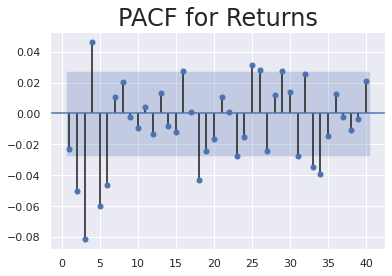

In [19]:
#Gráfica de autocorrelación parcial para los retornos
#La gráfica indica que el componenete de autorregresivo no debería contener más de 6 retrasos
sgt.plot_pacf(df.returns[1:], zero = False, lags = 40, method='ols')
plt.title("PACF for Returns",size=24)
plt.show()

In [21]:
#Como el modelo ARMA se complementa lo normal es que se reduzcan los retrasos para cada componente en el ARMA
#Empezamos con un ARMA(3,3)
model_ret_ar_3_ma_3 = ARMA(df.returns[1:], order=(3,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
#Podemos ver que el tanto el primer coficiente autorregresivo como el primer coeficiente de medias moviles no son significativos
#Un modelo de menos retrasos podría ser de mejor uso
results_ret_ar_3_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 3)   Log Likelihood               -7893.515
Method:                       css-mle   S.D. of innovations              1.166
Date:                Fri, 17 Jul 2020   AIC                          15803.030
Time:                        02:06:25   BIC                          15855.199
Sample:                    01-10-1994   HQIC                         15821.310
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.395      0.163      -0.008       0.045
ar.L1.returns    -0.1898      0.104     -1.827      0.068      -0.393       0.014
ar.L2.returns    -0.2942      0.087     -3.389      0.001      -0.464      -0.124
ar.L3.returns     0.4459      0.138      3.225      0.001       0.175       0.717
ma.L1.returns     0.1707      0.099      1.726      0.084      -0.023       0.365
ma.L2.returns     0.2277      0.084      2.701      0.007       0.062       0.393
ma.L3.returns    -0.5432      0.127     -4.270      0.000      -0.793      -0.294
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5168           -1.0283j            1.1508           -0.3241
AR.2           -0.5168           +1.0283j            1.1508            0.3241
AR.3            1.6932           -0.0000j            1.6932           -0.0000
MA.1           -0.5286           -0.9835j            1.1166           -0.3285
MA.2           -0.5286           +0.9835j            1.1166            0.3285
MA.3            1.4764           -0.0000j            1.4764           -0.0000
-----------------------------------------------------------------------------
"""

In [22]:
#Modificamos los grados de libertad, la diferencia ya es 4
#La prueba es significativa por lo que sugiere que un modelo ARMA(3,3) hace mejor estimaciones que un modelo ARMA(1,1)
LLR_test(results_ret_ar_1_ma_1, results_ret_ar_3_ma_3, DF = 4)

0.0

In [23]:
#Empecemos comprobante los modelos ARMA que consideran 5 componentes
#Modelo ARMA(3,2) 3 retrasos autorregresivos y 2 de medias móviles
model_ret_ar_3_ma_2 = ARMA(df.returns[1:], order=(3,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
#Podemos ver que todos los coeficientes son significativos
#Este es un posible buen modelo
results_ret_ar_3_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 2)   Log Likelihood               -7895.747
Method:                       css-mle   S.D. of innovations              1.166
Date:                Fri, 17 Jul 2020   AIC                          15805.495
Time:                        02:09:43   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.251      0.211      -0.011       0.048
ar.L1.returns    -0.6785      0.087     -7.799      0.000      -0.849      -0.508
ar.L2.returns    -0.5088      0.139     -3.670      0.000      -0.780      -0.237
ar.L3.returns    -0.1141      0.015     -7.655      0.000      -0.143      -0.085
ma.L1.returns     0.6568      0.087      7.536      0.000       0.486       0.828
ma.L2.returns     0.4474      0.141      3.175      0.002       0.171       0.724
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4929           -1.5100j            1.5885           -0.3002
AR.2           -0.4929           +1.5100j            1.5885            0.3002
AR.3           -3.4749           -0.0000j            3.4749           -0.5000
MA.1           -0.7340           -1.3025j            1.4951           -0.3317
MA.2           -0.7340           +1.3025j            1.4951            0.3317
-----------------------------------------------------------------------------
"""

In [25]:
#Modelo ARMA(2,3) 2 retrasos autorregresivos y 3 de medias móviles
model_ret_ar_2_ma_3 = ARMA(df.returns[1:], order=(2,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
#Este modelo contiene 2 coeficientes que no son significativos, el segundo retraso autorregresivo y el segundo de medias móviles
#Este no sería un buen modelo
results_ret_ar_2_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 3)   Log Likelihood               -7895.587
Method:                       css-mle   S.D. of innovations              1.166
Date:                Fri, 17 Jul 2020   AIC                          15805.174
Time:                        02:16:12   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.276      0.202      -0.010       0.048
ar.L1.returns    -0.5605      0.090     -6.245      0.000      -0.736      -0.385
ar.L2.returns    -0.4187      0.193     -2.172      0.030      -0.797      -0.041
ma.L1.returns     0.5378      0.090      6.000      0.000       0.362       0.714
ma.L2.returns     0.3540      0.195      1.818      0.069      -0.028       0.736
ma.L3.returns    -0.1158      0.016     -7.369      0.000      -0.147      -0.085
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6694           -1.3930j            1.5455           -0.3213
AR.2           -0.6694           +1.3930j            1.5455            0.3213
MA.1           -0.7270           -1.1772j            1.3836           -0.3381
MA.2           -0.7270           +1.1772j            1.3836            0.3381
MA.3            4.5096           -0.0000j            4.5096           -0.0000
-----------------------------------------------------------------------------
"""

In [26]:
#Ahora los modelos ARMA que consideran 4 componentes
#Modelo ARMA(3,1) 3 retrasos autorregresivos y 1 de medias móviles
model_ret_ar_3_ma_1 = ARMA(df.returns[1:], order=(3,1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
#En este caso todos los coeficientes son significativos por lo que este podría ser un buen modelo
results_ret_ar_3_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 1)   Log Likelihood               -7899.072
Method:                       css-mle   S.D. of innovations              1.167
Date:                Fri, 17 Jul 2020   AIC                          15810.144
Time:                        02:17:45   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.298      0.194      -0.010       0.047
ar.L1.returns    -0.5077      0.088     -5.769      0.000      -0.680      -0.335
ar.L2.returns    -0.0638      0.016     -4.023      0.000      -0.095      -0.033
ar.L3.returns    -0.1102      0.014     -7.850      0.000      -0.138      -0.083
ma.L1.returns     0.4839      0.088      5.500      0.000       0.311       0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5095           -0.0000j            1.5095           -0.5000
AR.2            0.4653           -2.4076j            2.4521           -0.2196
AR.3            0.4653           +2.4076j            2.4521            0.2196
MA.1           -2.0668           +0.0000j            2.0668            0.5000
-----------------------------------------------------------------------------
"""

In [27]:
#Como la diferencia es de 1, no tenemos que indicar los grados de libertad
#Realizamos el contraste y vemos que es significativo por lo que nos quedamos con el modeo ARMA(3,1)
LLR_test(results_ret_ar_3_ma_1, results_ret_ar_3_ma_2)

0.01

In [28]:
#Ahora los modelos ARMA que consideran 4 componentes
#Modelo ARMA(2,2) 2 retrasos autorregresivos y 2 de medias móviles
model_ret_ar_2_ma_2 = ARMA(df.returns[1:], order=(2,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
#Podemos observar que el segundo retraso autorregresivo no es significativo ni el segundo retraso de medias móviles
#Este no es un buen modelo
results_ret_ar_2_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 2)   Log Likelihood               -7913.223
Method:                       css-mle   S.D. of innovations              1.170
Date:                Fri, 17 Jul 2020   AIC                          15838.446
Time:                        02:20:22   BIC                          15877.573
Sample:                    01-10-1994   HQIC                         15852.156
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.394      0.163      -0.008       0.045
ar.L1.returns     0.7820      0.238      3.284      0.001       0.315       1.249
ar.L2.returns    -0.1563      0.177     -0.884      0.377      -0.503       0.190
ma.L1.returns    -0.8105      0.239     -3.388      0.001      -1.279      -0.342
ma.L2.returns     0.1177      0.187      0.628      0.530      -0.250       0.485
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5017           -0.3739j            2.5295           -0.0236
AR.2            2.5017           +0.3739j            2.5295            0.0236
MA.1            1.6107           +0.0000j            1.6107            0.0000
MA.2            5.2737           +0.0000j            5.2737            0.0000
-----------------------------------------------------------------------------
"""

In [29]:
#Ahora los modelos ARMA que consideran 4 componentes
#Modelo ARMA(1,3) 1 retraso autorregresivo y 3 de medias móviles
model_ret_ar_1_ma_3 = ARMA(df.returns[1:], order=(1,3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
#Obsrvamos que todos los coeficientes son significativos
#Este podría ser un buen modelo
results_ret_ar_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 3)   Log Likelihood               -7896.838
Method:                       css-mle   S.D. of innovations              1.167
Date:                Fri, 17 Jul 2020   AIC                          15805.676
Time:                        02:21:37   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.332      0.183      -0.009       0.047
ar.L1.returns    -0.4699      0.096     -4.901      0.000      -0.658      -0.282
ma.L1.returns     0.4474      0.095      4.691      0.000       0.260       0.634
ma.L2.returns    -0.0637      0.015     -4.113      0.000      -0.094      -0.033
ma.L3.returns    -0.1182      0.014     -8.200      0.000      -0.146      -0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1282           +0.0000j            2.1282            0.5000
MA.1           -1.4882           -1.1206j            1.8629           -0.3973
MA.2           -1.4882           +1.1206j            1.8629            0.3973
MA.3            2.4376           -0.0000j            2.4376           -0.0000
-----------------------------------------------------------------------------
"""

# Nota:

El contraste de log-verosimilitudes solo funciona con modelos Anidados.

**¿Que es un modelo Anidado?**

Supongamos que tenemos un modelos **ARMA($p_{1}$,$q_{1}$)** y **ARMA($p_{2}$,$q_{2}$)**. El segundo modelo esta Anidado al primero si y solo si:

$\bullet$ $p_{1}+q_{1}>p_{2}+q_{2}$

$\bullet$ $p_{1} \geq p_{2}$

$\bullet$ $q_{1} \geq q_{2}$

In [31]:
#En este caso el contraste de log-verosimilitudes no es posible usar dado que no se cumple la 3era condición
#Los compararemos a mano
#Dado que 2 modelos cumplieron con los coeficientes significativos, debemos checar los otros requisitos para saber cuál es mejor 
#Comparamos los log-verosimilitud y AIC del ARMA(3,2) Y ARMA(1,3), recordando que queremos que la log-verosimilitud seal ALTA y el AIC sea Bajo
#Nos quedamos con con el modelo ARMA(3,2)
print("\n ARMA(3,2): \tLL = ", results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)
print("\n ARMA(1,3): \tLL = ", results_ret_ar_1_ma_3.llf, "\tAIC = ", results_ret_ar_1_ma_3.aic)


 ARMA(3,2): 	LL =  -7895.7474585145965 	AIC =  15805.494917029193

 ARMA(1,3): 	LL =  -7896.837893752801 	AIC =  15805.675787505603


## Residuals for Returns

In [32]:
#Guardamos lo residuos del modelo ARMA(3,2) que fue nuestro modelo ganador
df['res_ret_ar_3_ma_2'] = results_ret_ar_3_ma_2.resid[1:]

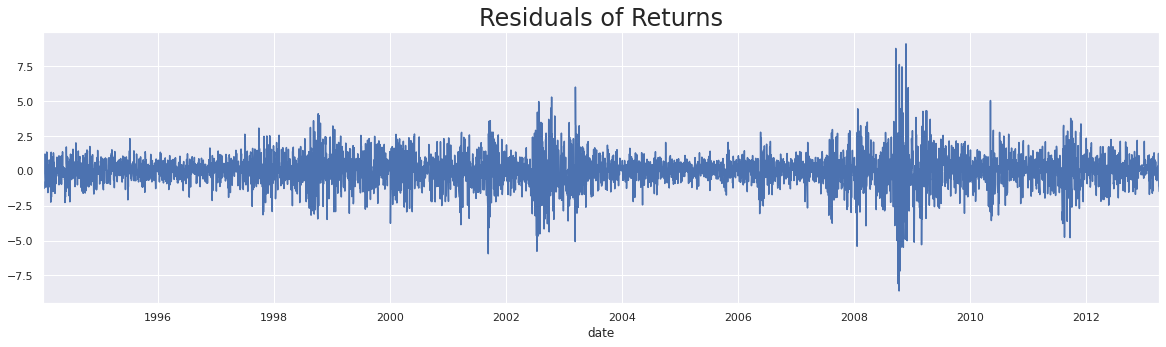

In [33]:
#Sugiere que la volatilidad en los retornos podría ser no del todo comprensible si utilizamos un modelo ARMA
df.res_ret_ar_3_ma_2.plot(figsize = (20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

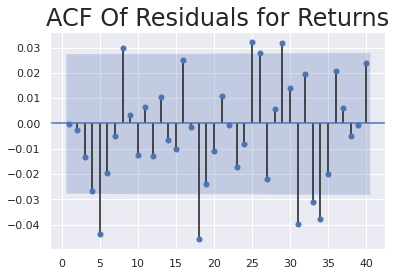

In [34]:
#Vemos que tenemos retrasos significativos
#Esto indicaria que hay un modelo mejor podría ser aquel que contemple un modelo de orden 5 en el componente autorregresivo o de medias móviles
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

## Reevaluating Model Selection

In [35]:
#Vamos a empezar re-evaluando modelo
#ARMA(5,5) dado que el gráfico ACF indica eso
model_ret_ar_5_ma_5 = ARMA(df.returns[1:], order=(5,5))
results_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
#Notamos que muchos no son significativos
results_ret_ar_5_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 5)   Log Likelihood               -7882.160
Method:                       css-mle   S.D. of innovations              1.163
Date:                Fri, 17 Jul 2020   AIC                          15788.321
Time:                        02:45:36   BIC                          15866.575
Sample:                    01-10-1994   HQIC                         15815.742
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.402      0.161      -0.008       0.045
ar.L1.returns    -0.0684      0.140     -0.490      0.624      -0.342       0.205
ar.L2.returns    -0.6722      0.146     -4.603      0.000      -0.958      -0.386
ar.L3.returns    -0.1152      0.141     -0.817      0.414      -0.392       0.161
ar.L4.returns     0.1779      0.129      1.381      0.167      -0.075       0.430
ar.L5.returns     0.1215      0.107      1.132      0.258      -0.089       0.332
ma.L1.returns     0.0443      0.138      0.322      0.748      -0.226       0.314
ma.L2.returns     0.6223      0.144      4.321      0.000       0.340       0.905
ma.L3.returns     0.0107      0.136      0.079      0.937      -0.256       0.277
ma.L4.returns    -0.1753      0.122     -1.436      0.151      -0.415       0.064
ma.L5.returns    -0.2240      0.104     -2.148      0.032      -0.428      -0.020
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0870           -1.0364j            1.0401           -0.2367
AR.2            0.0870           +1.0364j            1.0401            0.2367
AR.3            1.7715           -0.0000j            1.7715           -0.0000
AR.4           -1.7050           -1.1784j            2.0726           -0.4038
AR.5           -1.7050           +1.1784j            2.0726            0.4038
MA.1            0.1033           -1.0434j            1.0485           -0.2343
MA.2            0.1033           +1.0434j            1.0485            0.2343
MA.3            1.4855           -0.0000j            1.4855           -0.0000
MA.4           -1.2373           -1.0965j            1.6532           -0.3846
MA.5           -1.2373           +1.0965j            1.6532            0.3846
-----------------------------------------------------------------------------
"""

In [36]:
#Al revisar los 8 combinaciones restantes podemos ver que el modelo ARMA(5,1) es un buen modelo 
model_ret_ar_5_ma_1 = ARMA(df.returns[1:], order=(5,1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
#Todos sus coeficientes son significativos
results_ret_ar_5_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 1)   Log Likelihood               -7889.311
Method:                       css-mle   S.D. of innovations              1.165
Date:                Fri, 17 Jul 2020   AIC                          15794.623
Time:                        02:48:36   BIC                          15846.792
Sample:                    01-10-1994   HQIC                         15812.903
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.407      0.159      -0.007       0.045
ar.L1.returns     0.3440      0.131      2.624      0.009       0.087       0.601
ar.L2.returns    -0.0458      0.015     -3.005      0.003      -0.076      -0.016
ar.L3.returns    -0.0652      0.016     -4.010      0.000      -0.097      -0.033
ar.L4.returns     0.0741      0.018      4.068      0.000       0.038       0.110
ar.L5.returns    -0.0813      0.014     -5.688      0.000      -0.109      -0.053
ma.L1.returns    -0.3673      0.131     -2.801      0.005      -0.624      -0.110
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6158           -0.0000j            1.6158           -0.5000
AR.2            1.3793           -0.8614j            1.6261           -0.0888
AR.3            1.3793           +0.8614j            1.6261            0.0888
AR.4           -0.1156           -1.6929j            1.6968           -0.2608
AR.5           -0.1156           +1.6929j            1.6968            0.2608
MA.1            2.7223           +0.0000j            2.7223            0.0000
-----------------------------------------------------------------------------
"""

In [37]:
#Otro modelo bueno es el modelo ARMA(1,5) es un buen modelo 
model_ret_ar_1_ma_5 = ARMA(df.returns[1:], order=(1,5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
#Todos sus coeficientes son significativos
results_ret_ar_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 5)   Log Likelihood               -7890.973
Method:                       css-mle   S.D. of innovations              1.165
Date:                Fri, 17 Jul 2020   AIC                          15797.947
Time:                        02:51:04   BIC                          15850.116
Sample:                    01-10-1994   HQIC                         15816.228
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.419      0.156      -0.007       0.045
ar.L1.returns     0.3285      0.152      2.159      0.031       0.030       0.627
ma.L1.returns    -0.3534      0.152     -2.332      0.020      -0.650      -0.056
ma.L2.returns    -0.0404      0.015     -2.624      0.009      -0.071      -0.010
ma.L3.returns    -0.0679      0.017     -4.022      0.000      -0.101      -0.035
ma.L4.returns     0.0742      0.020      3.771      0.000       0.036       0.113
ma.L5.returns    -0.0683      0.015     -4.660      0.000      -0.097      -0.040
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0442           +0.0000j            3.0442            0.0000
MA.1           -1.1897           -1.1548j            1.6580           -0.3774
MA.2           -1.1897           +1.1548j            1.6580            0.3774
MA.3            1.5041           -0.0000j            1.5041           -0.0000
MA.4            0.9809           -1.6057j            1.8815           -0.1627
MA.5            0.9809           +1.6057j            1.8815            0.1627
-----------------------------------------------------------------------------
"""

In [38]:
#Los comparamos manualmente
#Nos quedamos con el ARMA(5,1) como modelo ganador
print("ARMA(5,1):  \t LL = ",results_ret_ar_5_ma_1.llf,"\t AIC = ",results_ret_ar_5_ma_1.aic)
print("ARMA(1,5):  \t LL = ",results_ret_ar_1_ma_5.llf,"\t AIC = ",results_ret_ar_1_ma_5.aic)

ARMA(5,1):  	 LL =  -7889.311282945847 	 AIC =  15794.622565891694
ARMA(1,5):  	 LL =  -7890.973460209621 	 AIC =  15797.946920419243


In [39]:
#Comparamos este modelo con el ARMA(3,2) que fue el modelo ganador en la primera iteración
#Nos quedamos con el ARMA(5,1)
#El empezar por modelos demasiado simplistas puede conducir a no escontrar un buen modelo para nuestro problema por es crucial revisuar los residuos del modelo
print("ARMA(3,2):  \t LL = ",results_ret_ar_3_ma_2.llf,"\t AIC = ",results_ret_ar_3_ma_2.aic)

ARMA(3,2):  	 LL =  -7895.7474585145965 	 AIC =  15805.494917029193


## Residuals for the New Model

In [41]:
#Guardamos los residuos del modelo ganador
df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid

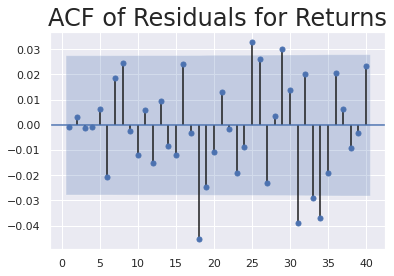

In [43]:
#Podemos ver que hay menos autocorrelación con los retrasos, hay significancia hasta el retraso 18
#Pero esto podría sobre ajustar el modelo, el complejizar el modelo demasiado nos llevara a una decepción cuando vea datos desconocidos
sgt.plot_acf(df.res_ret_ar_5_ma_1[1:], zero = False, lags = 40)
plt.title("ACF of Residuals for Returns",size=24)
plt.show()

## ARMA Models for Prices

Veamos ahora como funcionan los modelos ARMA para series que no son estacionarias

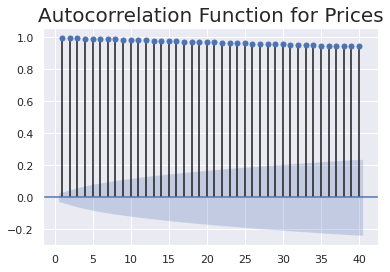

In [44]:
#Podemos ver que todos los retrasos son significativos
#Esto sugiere un modelo de medias móviles con infinitos retrasos, por suerte sabemos que esto es equivalente a un modelo siemple de autorregresión
sgt.plot_acf(df.market_value, unbiased=True, zero = False, lags = 40)
plt.title("Autocorrelation Function for Prices",size=20)
plt.show()

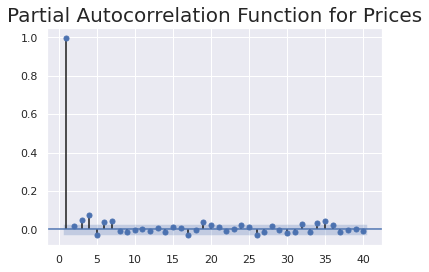

In [45]:
#6 coeficientes son significativos
sgt.plot_pacf(df.market_value, lags = 40, alpha = 0.05, zero = False , method = ('ols'))
plt.title("Partial Autocorrelation Function for Prices",size=20)
plt.show()

In [47]:
#Empecemos con un ARMA(1,1)
model_ar_1_ma_1 = ARMA(df.market_value, order=(1,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
#Observamos que el retraso para medias móviles no es significativo
results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 1)   Log Likelihood              -27621.792
Method:                       css-mle   S.D. of innovations             59.248
Date:                Fri, 17 Jul 2020   AIC                          55251.584
Time:                        03:02:00   BIC                          55277.670
Sample:                    01-07-1994   HQIC                         55260.725
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5101.4137    497.008     10.264      0.000    4127.296    6075.532
ar.L1.market_value     0.9985      0.001   1321.326      0.000       0.997       1.000
ma.L1.market_value    -0.0191      0.015     -1.278      0.201      -0.048       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
MA.1           52.3402           +0.0000j           52.3402            0.0000
-----------------------------------------------------------------------------
"""

In [48]:
#Anlicemos los residuos para darnos una idea de por donde podría estar el mejor modelo
df['res_ar_1_ma_1'] = results_ar_1_ma_1.resid

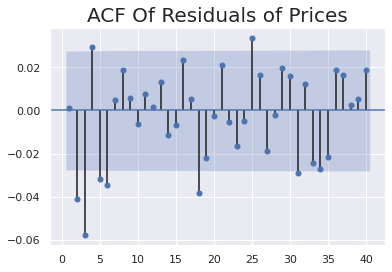

In [50]:
#Podemos ver que 5 de los primeros 6 retrasos son significativos
#Esto indica que un modelo que considere 6 retrasos en algúno de sus componenetes podría ser una respuesta
sgt.plot_acf(df.res_ar_1_ma_1, zero = False, lags = 40)
plt.title("ACF Of Residuals of Prices",size=20)
plt.show()

In [54]:
#Empezaremos con un ARMA(6,6)
model_ar_6_ma_6 = ARMA(df.market_value, order=(6,6))
#Para evitar errores debemos insertar la opción "start_ar_lags" e intentar con número mayores que el que queremos utilizar para el componente autorregresivo 
results_ar_6_ma_6 = model_ar_6_ma_6.fit(start_ar_lags = 11)
#Podemos ver que el retraso autorregresivo 4 y el de medias móviles no son significativos
results_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 6)   Log Likelihood              -27587.932
Method:                       css-mle   S.D. of innovations             58.849
Date:                Fri, 17 Jul 2020   AIC                          55203.864
Time:                        03:08:43   BIC                          55295.164
Sample:                    01-07-1994   HQIC                         55235.856
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6477    568.179      8.958      0.000    3976.037    6203.259
ar.L1.market_value     1.9275      0.032     59.960      0.000       1.864       1.990
ar.L2.market_value    -1.7357      0.040    -43.372      0.000      -1.814      -1.657
ar.L3.market_value     1.2673      0.034     36.745      0.000       1.200       1.335
ar.L4.market_value    -0.2372      0.159     -1.496      0.135      -0.548       0.073
ar.L5.market_value    -0.4064      0.166     -2.454      0.014      -0.731      -0.082
ar.L6.market_value     0.1840      0.049      3.770      0.000       0.088       0.280
ma.L1.market_value    -0.9486      0.035    -27.053      0.000      -1.017      -0.880
ma.L2.market_value     0.7798      0.032     24.155      0.000       0.716       0.843
ma.L3.market_value    -0.5083      0.031    -16.321      0.000      -0.569      -0.447
ma.L4.market_value    -0.1562      0.159     -0.982      0.326      -0.468       0.156
ma.L5.market_value     0.0953      0.057      1.681      0.093      -0.016       0.206
ma.L6.market_value     0.0670      0.024      2.798      0.005       0.020       0.114
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0857           -1.0503j            1.0537           -0.2370
AR.2            0.0857           +1.0503j            1.0537            0.2370
AR.3           -2.0251           -0.0000j            2.0251           -0.5000
AR.4            1.0011           -0.0000j            1.0011           -0.0000
AR.5            1.5306           -0.2671j            1.5537           -0.0275
AR.6            1.5306           +0.2671j            1.5537            0.0275
MA.1            0.1028           -1.0612j            1.0662           -0.2346
MA.2            0.1028           +1.0612j            1.0662            0.2346
MA.3            1.3623           -0.2795j            1.3906           -0.0322
MA.4            1.3623           +0.2795j            1.3906            0.0322
MA.5           -2.1760           -1.4332j            2.6056           -0.4073
MA.6           -2.1760           +1.4332j            2.6056            0.4073
-----------------------------------------------------------------------------
"""

In [55]:
#Después de analizar todas las posibles combinaciones para modelos ARMA que consideran un componente de orden 6
#Llegamos a que Modelo ARMA(6,2) es un modelocon todos sus coeficientes significativos
model_ar_6_ma_2 = ARMA(df.market_value, order=(6,2))
results_ar_6_ma_2 = model_ar_6_ma_2.fit()
results_ar_6_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(6, 2)   Log Likelihood              -27589.750
Method:                       css-mle   S.D. of innovations             58.871
Date:                Fri, 17 Jul 2020   AIC                          55199.500
Time:                        03:12:16   BIC                          55264.714
Sample:                    01-07-1994   HQIC                         55222.352
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6452    559.643      9.094      0.000    3992.765    6186.525
ar.L1.market_value     1.1801      0.052     22.528      0.000       1.077       1.283
ar.L2.market_value    -1.0823      0.075    -14.355      0.000      -1.230      -0.934
ar.L3.market_value     0.8181      0.068     12.070      0.000       0.685       0.951
ar.L4.market_value     0.0807      0.027      2.937      0.003       0.027       0.135
ar.L5.market_value    -0.0879      0.025     -3.564      0.000      -0.136      -0.040
ar.L6.market_value     0.0891      0.015      5.923      0.000       0.060       0.119
ma.L1.market_value    -0.2013      0.051     -3.965      0.000      -0.301      -0.102
ma.L2.market_value     0.8589      0.064     13.317      0.000       0.733       0.985
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0011           -0.0000j            1.0011           -0.0000
AR.2            0.0927           -1.0633j            1.0673           -0.2362
AR.3            0.0927           +1.0633j            1.0673            0.2362
AR.4           -2.2407           -0.0000j            2.2407           -0.5000
AR.5            1.0201           -1.8300j            2.0951           -0.1691
AR.6            1.0201           +1.8300j            2.0951            0.1691
MA.1            0.1172           -1.0726j            1.0790           -0.2327
MA.2            0.1172           +1.0726j            1.0790            0.2327
-----------------------------------------------------------------------------
"""

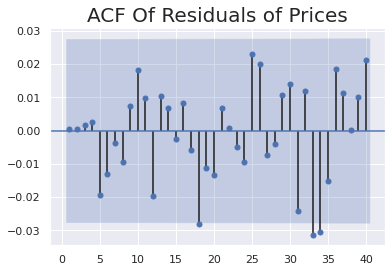

In [57]:
#Extraemos los residuos
df['res_ar_6_ma_2'] = results_ar_6_ma_2.resid
#Observamos que solo 3 residuos son significativos pero en general se asemeja a un ACF de ruido blanco
#Esta parece una muy buena posible solución
sgt.plot_acf(df.res_ar_6_ma_2, zero = False, lags = 40)
plt.title("ACF Of Residuals of Prices",size=20)
plt.show()

## ARMA for Returns vs ARMA for Prices

In [58]:
#Ahora vamos a compararlo con el ARMA(5,1) que contiene a los retornos, es decir a una serie estacionaria
#Esto porque el ARMA(6,2) contiene una serie no estacionaria que son los precios y habiamos dicho que los modelos ARMA no funcionan bien con series no estacionarias
#Podemos ver que la log verosimilitud de el ARMA(5,1) es más grande y el AIC  es más bajo, esto indica que es un mejor modelo dado que tiene una serie estacionaria
print("ARMA(6,2):  \t LL = ", results_ar_6_ma_2.llf, "\t AIC = ", results_ar_6_ma_2.aic)
print("ARMA(5,1):  \t LL = ", results_ret_ar_5_ma_1.llf, "\t AIC = ", results_ret_ar_5_ma_1.aic)

ARMA(6,2):  	 LL =  -27589.750018536673 	 AIC =  55199.50003707335
ARMA(5,1):  	 LL =  -7889.311282945847 	 AIC =  15794.622565891694
